## Goal of the Competition

The aim is to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0) that are being investigated. 

The models were trained on measurements of health characteristics.
This work will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

For more detail please visit: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview
.

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats


from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
from scipy.stats import probplot

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay 

## EDA

In [3]:
# load the dataset
df = pd.read_csv(r"/home/dgh/Documents/DS_Code_folder/ds-ml-project/data/train.csv")

In [4]:
df.sample(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
321,8006877fc82a,0.141009,3302.24488,178.403865,5.729450,8.138688,3.012060,0.097440,8.551814,3.429664,...,0.173229,1.27252,0.067730,10.241502,380.087267,11838.817120,16.443099,54.454384,21.978000,0
210,514d2ac4fdb5,0.247834,2267.05116,85.200147,14.884182,8.138688,6.369621,0.025578,14.727774,1.229900,...,0.173229,1.12810,0.067730,22.696880,72.611063,43395.398780,38.010015,39.180562,21.978000,0
49,1360fac6a227,0.478576,5192.25520,194.576478,13.230384,8.138688,7.290957,0.025578,9.705080,8.588216,...,10.690335,1.85861,0.067730,12.418170,72.611063,434.357883,34.411808,36.769312,0.050038,1
511,cf84868cd1ce,1.213532,4386.17256,85.200147,43.596469,10.739712,3.800511,0.025578,14.305540,5.952716,...,137.932739,2.29622,0.338650,23.673590,223.235180,1632.752964,32.406189,123.257956,0.177654,1
334,8296caddae14,0.337567,2898.91679,172.603671,23.574364,8.138688,4.119435,0.049938,10.347884,1.229900,...,5.211162,1.64459,0.203190,23.868932,72.611063,245.396709,31.215469,24.529164,0.100930,0
533,d75aafac1e86,0.700772,2292.17439,283.930818,79.862339,8.138688,6.387339,0.025578,15.244538,1.229900,...,10.219260,1.71883,0.501202,33.412784,72.611063,2671.149312,39.669581,12.849712,0.107457,0
279,6c6db7987cd5,0.354659,1821.33072,114.183699,108.692312,8.138688,4.296615,0.025578,7.486776,1.229900,...,1.225413,1.00398,0.067730,17.831934,103.918759,23672.744100,26.586545,51.882384,0.110512,0
560,e6aa6fa49abd,0.252107,2195.45062,143.959770,14.890376,13.985748,3.463869,0.025578,7.272508,1.229900,...,0.173229,0.49706,0.169325,14.036718,72.611063,7079.205276,38.285369,35.725080,21.978000,0
494,c809ac237df8,0.636677,3836.39454,87.730112,42.466064,8.138688,3.038637,0.025578,11.457036,2.572248,...,10.816877,1.87833,0.067730,18.408658,72.611063,3533.304078,28.048898,31.118628,0.041704,1
470,ba4443b0170c,0.705045,2319.53491,315.448689,414.084385,31.031370,5.528016,0.025578,3.396778,1.229900,...,14.488115,1.48625,0.528294,32.770946,72.611063,515.359989,27.635867,96.486008,0.017135,1


In [5]:
df.shape

(617, 58)

In [6]:
df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [8]:
#treating missing values
print(df.isna().sum()[df.isna().sum() > 0])

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64


In [9]:
print(df['BQ'].sample(20))

395     50.177510
90      96.387605
402     60.292725
188     21.308900
347     63.960565
473      7.953065
68      14.853710
216     32.481745
436    264.318930
174    224.298315
281           NaN
520    135.582435
14      73.244785
391     71.624475
607     16.367215
532    163.721645
546    344.644105
229    155.448165
373      7.033500
392     56.393040
Name: BQ, dtype: float64


In [10]:
print(df['EL'].sample(20))

135    109.125159
254     38.187864
336     13.514358
204    109.125159
154    109.125159
353    109.125159
14      37.670061
533     74.745957
297     35.705670
356     44.720247
402    109.125159
320     22.140690
473     39.129948
57     109.125159
373     22.467159
259    109.125159
269     20.805642
9       91.473739
235           NaN
532     17.946357
Name: EL, dtype: float64


In [11]:
# missing values dropped as the dataset is significant enough to allow for that
df.dropna()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,0.173229,1.89486,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


In [12]:
# checking shape after dropping values - to make sure no feature entirely dropped
df.shape

(617, 58)

In [13]:
print(df['EJ']) # only data not represented by numerical value (asside from ID) so will be treated 

0      B
1      A
2      B
3      B
4      B
      ..
612    A
613    B
614    A
615    B
616    A
Name: EJ, Length: 617, dtype: object


In [14]:
df['EJ'].value_counts()

EJ
B    395
A    222
Name: count, dtype: int64

In [15]:
# as B is more prevalent it will be given the positive weighting value
df['EJ'] = df['EJ'].replace({'B': 1, 'A': 0})

/tmp/ipykernel_700296/2237488873.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [16]:
# understanding medical condition spread
print(df['Class'].value_counts())

Class
0    509
1    108
Name: count, dtype: int64


## Baselining and Initial model building

In [17]:
# Define variables 
X = df.drop(['Id','Class'], axis=1)
y = df['Class']

# Split the data into training and test sets for model building
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [18]:
# Train and evaluate Random Forest classifier
rf_classifier = RandomForestClassifier(random_state = 50)
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict_proba(X_test_scaled)

train_acc = accuracy_score(y_train, rf_classifier.predict(X_train_scaled))
test_acc = accuracy_score(y_test, rf_classifier.predict(X_test_scaled))

print('Accuracy train:', train_acc)
print('Accuracy test:', test_acc)
print('ROC score', roc_auc_score(y_test, rf_classifier.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 1.0
Accuracy test: 0.8870967741935484
ROC score 0.9164438502673797


In [19]:
# Train and evaluate XGBoost classifier
xgb_model = XGBClassifier(random_state = 50)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)

train_acc = accuracy_score(y_train, xgb_model.predict(X_train_scaled))
test_acc = accuracy_score(y_test, xgb_model.predict(X_test_scaled))
print('Accuracy train:', train_acc)
print('Accuracy test:', test_acc)
print('ROC score', roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 1.0
Accuracy test: 0.9032258064516129
ROC score 0.9153297682709449


Text(0.5, 1.0, 'Random Forest Model')

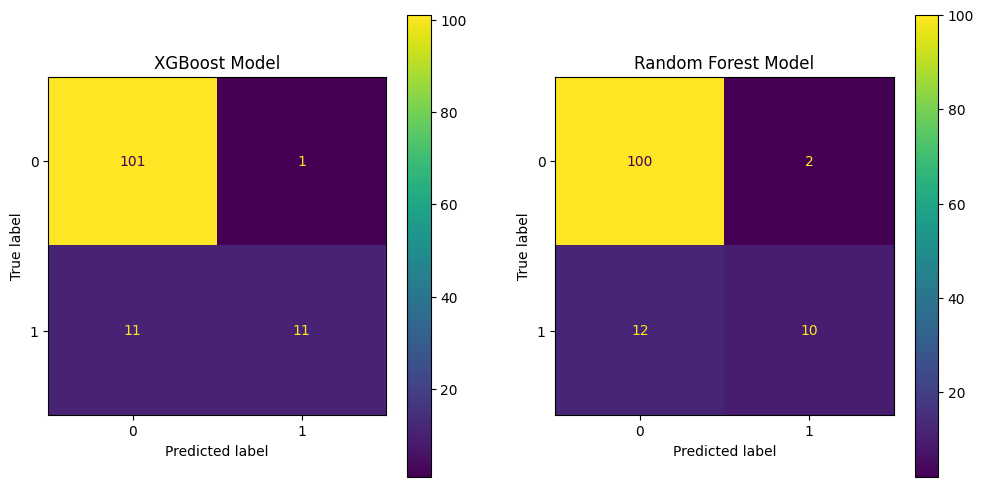

In [20]:
# Visualization
cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test_scaled))
cm_rf = confusion_matrix(y_test, rf_classifier.predict(X_test_scaled))

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels= xgb_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_classifier.classes_)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
disp_xgb.plot(ax=ax[0])
ax[0].set_title('XGBoost Model')


disp_rf.plot(ax=ax[1])
ax[1].set_title('Random Forest Model')


In [21]:
# Further exploration of XGBoost Classifier
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=50, ...)

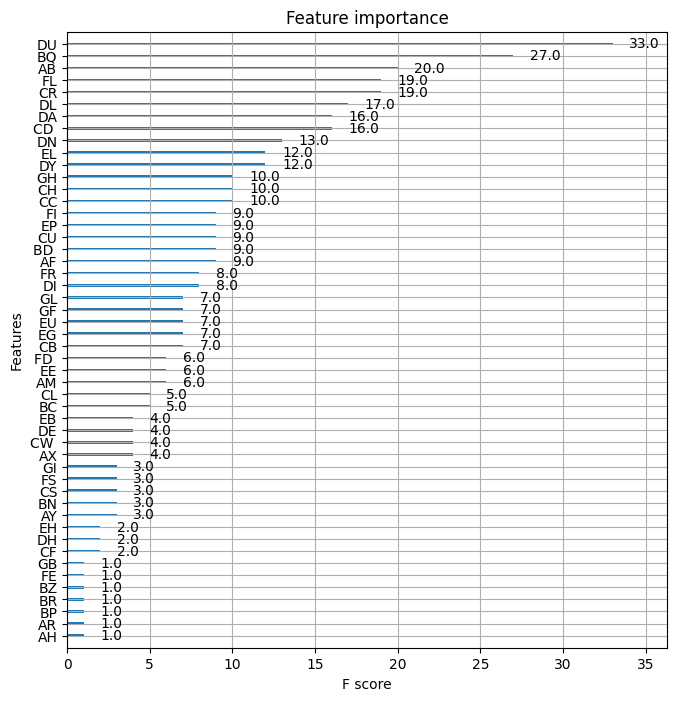

In [22]:
from xgboost import plot_importance
axsub = plot_importance(xgb_model)

# getting the original names back for the features 
myfeatures = X_train.columns
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(myfeatures))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
# Vizualization of feature importance
plt.gcf().set_size_inches(10, 8)  
plt.subplots_adjust(left=0.3)
plt.show()

56
29
Accuracy train: 1.0


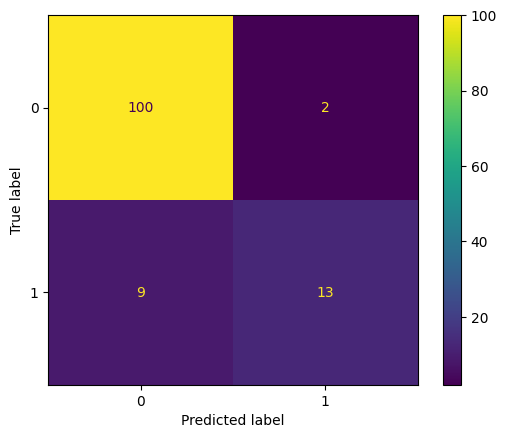

In [23]:
# Calculate feature importance scores
importance_scores = xgb_model.feature_importances_
print(len(importance_scores))
# Determine the threshold for excluding features
threshold = 0.01  # Adjust this threshold based on your preference

# Exclude features with importance scores below the threshold
selected_features_indices = [i for i, score in enumerate(importance_scores) if score >= threshold]
print(len(selected_features_indices))
selected_features = [X_train.columns[i] for i in selected_features_indices]

# Retrain the XGBoost model using the reduced feature set
xgb_classifier_reduced = xgb.XGBClassifier()
X_train_reduced = X_train.iloc[:, selected_features_indices]
X_test_reduced = X_test.iloc[:, selected_features_indices]

xgb_classifier_reduced.fit(X_train_reduced, y_train)
train_acc = accuracy_score(y_train, xgb_classifier_reduced.predict(X_train_reduced))
print('Accuracy train:', train_acc)


cm_xgb_reduced = confusion_matrix(y_test, xgb_classifier_reduced.predict(X_test_reduced))
disp_xgb_reduced = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_reduced, display_labels= xgb_classifier_reduced.classes_)

disp_xgb_reduced.plot()



In [24]:
# Further exploration of Random Forest Classifier
rf_classifier

RandomForestClassifier(random_state=50)

In [25]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(df['Class'])
print(neg)
print(pos)

# Calculate total samples.
total = neg + pos
print(total)
# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

509
108
617
Weight for class 0: 0.61
Weight for class 1: 2.86


In [26]:
# Adjusting the criterion: Log loss provides a continuous measure of how well the model's predicted probabilities align with the true labels.
# Minimizing log loss encourages the model to make accurate probability predictions.
rf_classifier_adjusted = RandomForestClassifier(random_state = 50, n_estimators=50, criterion='log_loss', max_depth=5, min_samples_split = 5, class_weight = weight)
rf_classifier_adjusted.fit(X_train_scaled, y_train)

# y_pred_rf = rf_classifier_adjusted.predict_proba(X_test_scaled)

train_acc_adj = accuracy_score(y_train, rf_classifier_adjusted.predict(X_train_scaled))
test_acc_adj = accuracy_score(y_test, rf_classifier_adjusted.predict(X_test_scaled))

print('Accuracy train:', train_acc_adj)
print('Accuracy test:', test_acc_adj)
print('ROC score', roc_auc_score(y_test, rf_classifier_adjusted.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 0.9918864097363083
Accuracy test: 0.9032258064516129
ROC score 0.9144385026737968


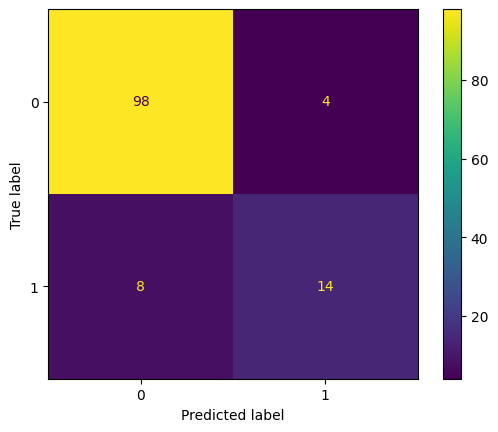

In [27]:
# Visualizing adjusted model
cm = confusion_matrix(y_test, rf_classifier_adjusted.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_classifier_adjusted.classes_)
disp.plot()

In [28]:
# Exploring feature importance in this model
rf_feature_importance = rf_classifier_adjusted.feature_importances_
print(rf_feature_importance)

[6.04645917e-02 4.97489009e-02 4.59502096e-03 1.21505197e-02
 9.15561287e-03 9.19369265e-03 2.98566155e-03 7.05678082e-03
 2.39115760e-02 4.82409585e-03 1.16687976e-02 1.10585519e-02
 5.39591867e-02 8.03322163e-03 1.85347036e-03 8.20692137e-03
 1.36322844e-02 1.99979364e-02 7.85924486e-03 4.51196829e-03
 6.70981179e-03 6.96900243e-02 9.13626431e-03 1.79087396e-02
 4.48881935e-03 2.56048867e-02 2.02482585e-02 6.62790681e-03
 1.32046209e-02 3.54739837e-02 2.22639665e-02 7.85091148e-03
 9.50642625e-02 4.85327142e-18 7.22904898e-03 1.39147138e-02
 2.90290913e-02 3.57128870e-03 3.15756393e-02 1.25683678e-03
 1.29831885e-02 9.37404978e-03 1.30533090e-02 5.98666751e-03
 2.65717958e-02 1.14425614e-02 1.07492721e-02 5.39513830e-02
 7.36046907e-03 3.80939012e-03 2.54814197e-03 6.44158967e-03
 1.25862481e-02 6.40751086e-03 2.66931957e-03 6.83479916e-02]


<Axes: title={'center': 'Feature Importances (Most to Least)'}>

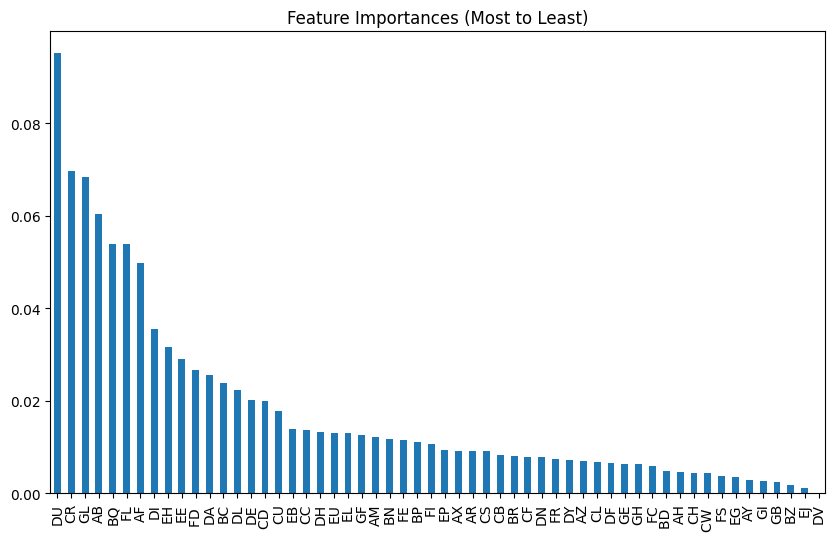

In [29]:
# importances = rf_classifier_adjusted.feature_importances_
myfeatures = X_train.columns
rf_importances = pd.Series(rf_feature_importance, index=myfeatures)
rf_importances_sorted = rf_importances.sort_values(ascending=False)
rf_importances_sorted.plot(kind='bar', figsize=(10, 6), title='Feature Importances (Most to Least)')


In [30]:
# Excluding features based on threshold 
# importance_scores = rf_classifier_adjusted.feature_importances_
threshold = 0.02# Adjust this threshold based on your preference
selected_features_indices = [i for i, score in enumerate(rf_feature_importance) if score >= threshold]
X_train_reduced_rf = X_train.iloc[:, selected_features_indices]
features_for_prediction = X_train_reduced_rf.columns
print(features_for_prediction)
rf_classifier_reduced = RandomForestClassifier()
rf_classifier_reduced.fit(X_train_reduced_rf, y_train)

Index(['AB', 'AF', 'BC', 'BQ', 'CR', 'DA', 'DE', 'DI', 'DL', 'DU', 'EE', 'EH',
       'FD ', 'FL', 'GL'],
      dtype='object')


RandomForestClassifier()

In [31]:
train_acc_adj_rf = accuracy_score(y_train, rf_classifier_reduced.predict(X_train_reduced_rf))
print('Accuracy train:', train_acc_adj_rf)

Accuracy train: 1.0


Class
0    407
1     86
Name: count, dtype: int64


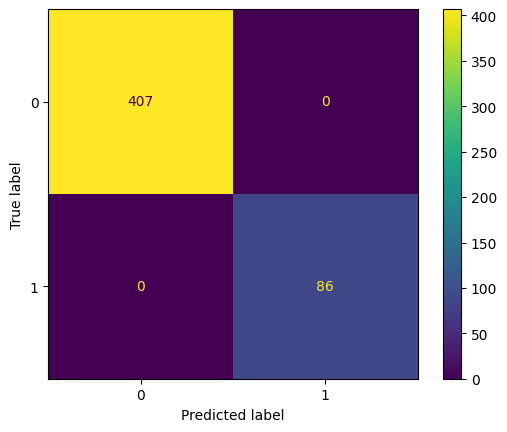

In [32]:
cm = confusion_matrix(y_train, rf_classifier_reduced.predict(X_train_reduced_rf))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_classifier_reduced.classes_)
disp.plot()
print(y_train.value_counts())

## TEST Data 
Predictiones made using Random Forest Classifier (based on reduced features)

In [33]:
# test_predictions_df = pd.read_csv(r"/home/dgh/Documents/DS_Code_folder/ds-ml-project/data/test.csv")
test_predictions_df = X_test[:15]
formated_data = test_predictions_df[features_for_prediction]
print(formated_data)

           AB           AF         BC          BQ        CR        DA  \
161  0.226469   2150.98554   9.944620    4.300855  0.861150  39.28888   
503  0.538398   4059.43626   1.229900  291.517735  0.690675  56.52384   
8    0.346113   3238.43674   3.626448         NaN  1.050375  76.77356   
411  0.262790   1076.39180   1.229900   19.342125  0.816675  43.75476   
286  0.230742   2678.04944   1.229900   44.839865  0.344775  67.61288   
197  0.764867   1165.43691   1.229900    4.931265  0.470325  49.35748   
575  0.781959   2388.98286   3.598336  108.761355  0.509025  98.90508   
561  0.311929   1909.95838   1.229900   37.175955  0.905025  30.04672   
54   0.175193   4756.23170   4.821208  167.334780  0.711450  43.92936   
32   0.461484   4253.98732   4.933656   72.288750  0.681825  51.41000   
257  0.538398   1524.53950   4.076240    5.363695  0.653250  63.25952   
232  3.068014  13743.65190  21.554876  344.644105  1.634400  29.11940   
184  0.166647   6419.79415  10.598224   28.522145  

In [34]:
predictions = rf_classifier_reduced.predict_proba(formated_data)

print(predictions)

[[0.99 0.01]
 [0.94 0.06]
 [0.97 0.03]
 [1.   0.  ]
 [0.86 0.14]
 [0.91 0.09]
 [0.73 0.27]
 [1.   0.  ]
 [0.99 0.01]
 [0.33 0.67]
 [0.98 0.02]
 [0.43 0.57]
 [0.92 0.08]
 [0.88 0.12]
 [1.   0.  ]]


In [35]:
probabilities_class_1 = predictions[:, 1]
formated_data['probability_class_1'] =probabilities_class_1
new_data = formated_data.drop(features_for_prediction, axis=1)
print(new_data)

     probability_class_1
161                 0.01
503                 0.06
8                   0.03
411                 0.00
286                 0.14
197                 0.09
575                 0.27
561                 0.00
54                  0.01
32                  0.67
257                 0.02
232                 0.57
184                 0.08
450                 0.12
416                 0.00
